## Google Driveのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## データセットの準備

In [ ]:
# kaggle ライブラリのインストール
!pip install kaggle

# 一時フォルダに .kaggleフォルダを作成
!mkdir ~/.kaggle

# MyDrive の kaggle.json を一時フォルダ内の .kaggleフォルダにコピー
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/

# アクセス権限の設定
!chmod 600 ~/.kaggle/kaggle.json

!mkdir ~/.kaggle

# zipファイルのダウンロード
!kaggle datasets download -d ashaheedq/video-games-sales-2019 -p /content/drive/MyDrive/kaggle

# 解凍
!unzip /content/drive/MyDrive/kaggle/video-games-sales-2019.zip -d /content/drive/MyDrive/kaggle

!rm /content/drive/MyDrive/kaggle/video-games-sales-2019.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/3.98M [00:00<?, ?B/s]
100% 3.98M/3.98M [00:00<00:00, 64.9MB/s]
Archive:  /content/drive/MyDrive/kaggle/video-games-sales-2019.zip
replace /content/drive/MyDrive/kaggle/vgsales-12-4-2019-short.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: None


## CUDAのバージョン確認

In [ ]:
!nvcc -V

['nvcc: NVIDIA (R) Cuda compiler driver',
 'Copyright (c) 2005-2020 NVIDIA Corporation',
 'Built on Mon_Oct_12_20:09:46_PDT_2020',
 'Cuda compilation tools, release 11.1, V11.1.105',
 'Build cuda_11.1.TC455_06.29190527_0']

## 変更可能なCUDAのバージョン

In [ ]:
!ls -d /usr/local/cuda-*
!which nvcc

/usr/local/cuda-10.0  /usr/local/cuda-11    /usr/local/cuda-11.1
/usr/local/cuda-10.1  /usr/local/cuda-11.0
/usr/local/cuda/bin/nvcc


## CUDAのバージョン変更

In [ ]:
import os
p = os.getenv('PATH')
ld = os.getenv('LD_LIBRARY_PATH')
os.environ['PATH'] = f"/usr/local/cuda-10.1/bin:{p}"
os.environ['LD_LIBRARY_PATH'] = f"/usr/local/cuda-10.1/lib64:{ld}"
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


## AutoGluon

In [ ]:
!pip install -U "mxnet_cu101<2.0.0" # GPU用
!pip install autogluon
!pip install japanize-matplotlib

     |████████████████████████████████| 358.1 MB 5.1 kB/s 


## データの読込

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/kaggle/vgsales-12-4-2019.csv")
df.head(3)

,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,User_Score,Total_Shipped,Global_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
0,1,Wii Sports,wii-sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,7.7,NaN,82.86,NaN,NaN,NaN,NaN,NaN,2006.0,NaN,http://www.vgchartz.com/game/2667/wii-sports/?...,1,NaN,/games/boxart/full_2258645AmericaFrontccc.jpg
1,2,Super Mario Bros.,super-mario-bros,Platform,NaN,NES,Nintendo,Nintendo EAD,NaN,10.0,NaN,40.24,NaN,NaN,NaN,NaN,NaN,1985.0,NaN,http://www.vgchartz.com/game/6455/super-mario-...,1,NaN,/games/boxart/8972270ccc.jpg
2,3,Mario Kart Wii,mario-kart-wii,Racing,E,Wii,Nintendo,Nintendo EAD,NaN,8.2,9.1,37.14,NaN,NaN,NaN,NaN,NaN,2008.0,11th Apr 18,http://www.vgchartz.com/game/6968/mario-kart-w...,1,8.7,/games/boxart/full_8932480AmericaFrontccc.jpg


In [ ]:
import time
import random
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from natsort import natsorted 

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from autogluon.tabular import TabularPredictor

import warnings
warnings.simplefilter('ignore')

In [ ]:
# シード値の固定
SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [ ]:
# 目的変数にNull値があっても学習・予測できるが、評価時にエラーが出るのでNull値を補完する

df["Global_Sales"] = df["Global_Sales"].fillna(df["Global_Sales"].mean())

In [ ]:
train, test = train_test_split(
                            df.drop(["NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales"], axis=1), 
                            test_size=0.3,
                            shuffle=True, 
                            random_state=SEED
                        )

## AutoGluon

Fold 0
特徴量の重要度


,importance,stddev,p_value,n,p99_high,p99_low
Rank,0.422833,0.115054,0.011901,3,1.082104,-0.236438
Total_Shipped,0.271984,0.088651,0.016818,3,0.779962,-0.235994
Platform,0.004397,0.004371,0.111782,3,0.029446,-0.020651
Critic_Score,0.003483,0.011542,0.326674,3,0.069620,-0.062654
Name,0.003204,0.003445,0.124251,3,0.022941,-0.016534
Vgchartzscore,0.000086,0.000358,0.358957,3,0.002137,-0.001965
User_Score,0.000014,0.000024,0.212656,3,0.000149,-0.000122
basename,0.000000,0.000000,0.500000,3,0.000000,0.000000
Genre,0.000000,0.000000,0.500000,3,0.000000,0.000000
VGChartz_Score,0.000000,0.000000,0.500000,3,0.000000,0.000000


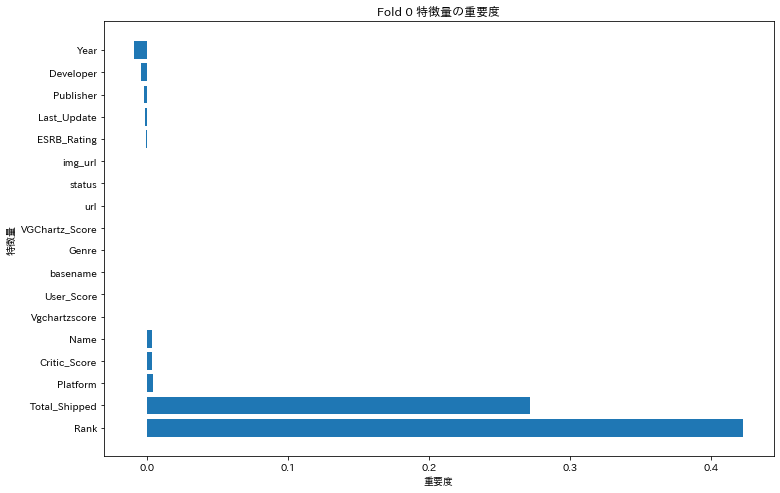


リーダーボード


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-0.127800,-0.108235,1.584506,0.665612,11.059127,0.006327,0.000617,0.163395,2,True,4
1,LightGBMXT,-0.143911,-0.142218,1.364667,0.456414,10.738332,1.364667,0.456414,10.738332,1,True,3
2,KNeighborsDist,-0.209304,-0.181224,0.106939,0.104411,0.082000,0.106939,0.104411,0.082000,1,True,2
3,KNeighborsUnif,-0.223602,-0.182728,0.106574,0.104171,0.075400,0.106574,0.104171,0.075400,1,True,1



Fold 1
特徴量の重要度


,importance,stddev,p_value,n,p99_high,p99_low
Rank,0.371047,0.054405,0.003545,3,0.682795,0.059298
Total_Shipped,0.144075,0.084069,0.048612,3,0.625803,-0.337652
Critic_Score,0.020258,0.022982,0.133187,3,0.151950,-0.111433
Platform,0.013570,0.022487,0.202817,3,0.142421,-0.115282
Developer,0.001998,0.005307,0.290617,3,0.032407,-0.028411
img_url,0.000017,0.000017,0.118896,3,0.000116,-0.000083
url,0.000000,0.000000,0.500000,3,0.000000,0.000000
status,0.000000,0.000000,0.500000,3,0.000000,0.000000
Genre,0.000000,0.000000,0.500000,3,0.000000,0.000000
basename,0.000000,0.000000,0.500000,3,0.000000,0.000000


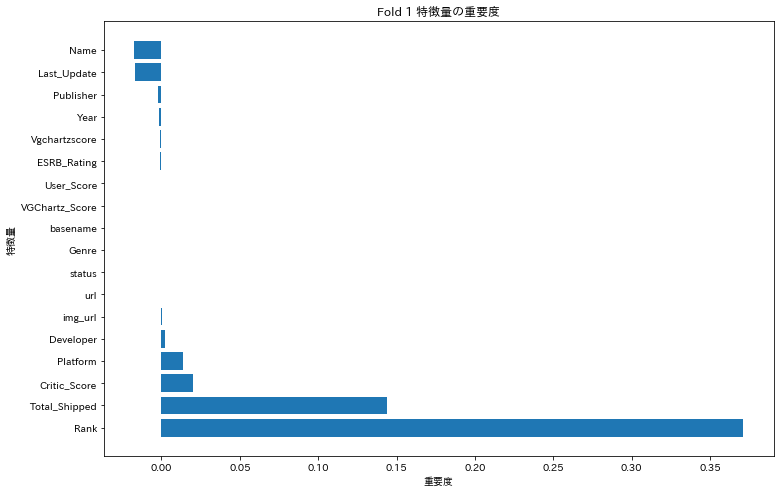


リーダーボード


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT,-0.298412,-0.094930,2.395871,0.764372,14.678136,2.395871,0.764372,14.678136,1,True,3
1,WeightedEnsemble_L2,-0.299251,-0.087174,2.511100,0.870239,14.914958,0.007962,0.000796,0.155250,2,True,4
2,KNeighborsDist,-0.385875,-0.252377,0.107702,0.105870,0.083692,0.107702,0.105870,0.083692,1,True,2
3,KNeighborsUnif,-0.391688,-0.255189,0.107266,0.105071,0.081572,0.107266,0.105071,0.081572,1,True,1



Fold 2
特徴量の重要度


,importance,stddev,p_value,n,p99_high,p99_low
Rank,0.406456,0.109422,0.011658,3,1.033457,-0.220545
Total_Shipped,0.162085,0.068460,0.027319,3,0.554369,-0.230198
Name,0.041634,0.073653,0.215391,3,0.463673,-0.380405
Last_Update,0.001881,0.001888,0.113288,3,0.012700,-0.008938
Vgchartzscore,0.000187,0.001124,0.400226,3,0.006626,-0.006252
img_url,0.000026,0.000013,0.035379,3,0.000098,-0.000046
url,0.000000,0.000000,0.500000,3,0.000000,0.000000
Genre,0.000000,0.000000,0.500000,3,0.000000,0.000000
basename,0.000000,0.000000,0.500000,3,0.000000,0.000000
status,0.000000,0.000000,0.500000,3,0.000000,0.000000


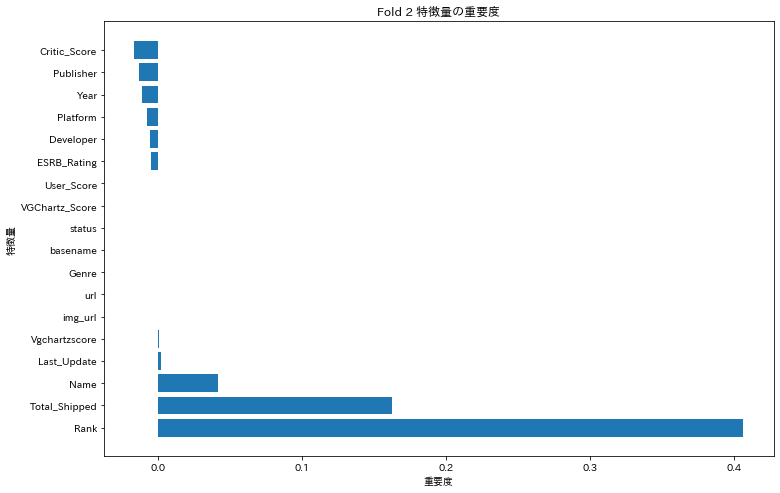


リーダーボード


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-0.081320,-0.150123,2.885364,0.951244,15.096838,0.009082,0.000647,0.154123,2,True,4
1,LightGBMXT,-0.084043,-0.181780,2.768701,0.845456,14.864660,2.768701,0.845456,14.864660,1,True,3
2,KNeighborsDist,-0.171357,-0.256534,0.107581,0.105141,0.078056,0.107581,0.105141,0.078056,1,True,2
3,KNeighborsUnif,-0.180776,-0.270586,0.109093,0.105888,0.082800,0.109093,0.105888,0.082800,1,True,1



Fold 3
特徴量の重要度


,importance,stddev,p_value,n,p99_high,p99_low
Rank,0.566395,0.081788,0.003439,3,1.035051,0.097738
Total_Shipped,0.195857,0.082528,0.027199,3,0.668749,-0.277035
Year,0.008724,0.001630,0.005716,3,0.018062,-0.000614
ESRB_Rating,0.003050,0.002233,0.070861,3,0.015846,-0.009747
Developer,0.002703,0.001249,0.032184,3,0.009860,-0.004454
Publisher,0.001999,0.005680,0.302088,3,0.034545,-0.030547
User_Score,0.000765,0.001414,0.223768,3,0.008869,-0.007338
img_url,0.000114,0.000011,0.001568,3,0.000177,0.000050
url,0.000000,0.000000,0.500000,3,0.000000,0.000000
status,0.000000,0.000000,0.500000,3,0.000000,0.000000


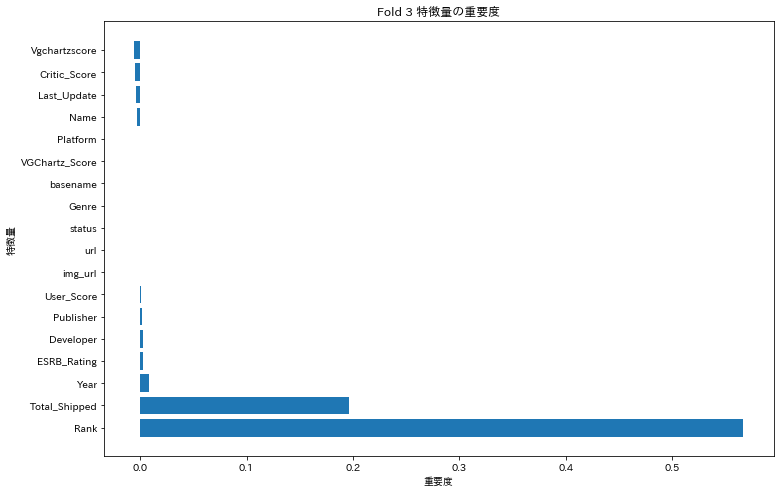


リーダーボード


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-0.148161,-0.065482,2.629019,0.837215,13.996766,0.008492,0.000618,0.156078,2,True,4
1,LightGBMXT,-0.155038,-0.067915,2.513574,0.731820,13.753784,2.513574,0.731820,13.753784,1,True,3
2,KNeighborsDist,-0.214704,-0.211180,0.106953,0.104777,0.086905,0.106953,0.104777,0.086905,1,True,2
3,KNeighborsUnif,-0.230332,-0.216366,0.106749,0.104708,0.082991,0.106749,0.104708,0.082991,1,True,1



Fold 4
特徴量の重要度


,importance,stddev,p_value,n,p99_high,p99_low
Rank,8.910580e-01,2.564540e-01,0.013259,3,2.360568e+00,-5.784518e-01
Total_Shipped,5.686096e-01,2.292562e-01,0.025073,3,1.882273e+00,-7.450537e-01
Year,2.772285e-04,5.431246e-04,0.234955,3,3.389392e-03,-2.834935e-03
Vgchartzscore,1.941772e-04,3.352671e-04,0.210719,3,2.115295e-03,-1.726940e-03
basename,5.391974e-09,1.059102e-08,0.235450,3,6.607970e-08,-5.529575e-08
Genre,0.000000e+00,0.000000e+00,0.500000,3,0.000000e+00,0.000000e+00
img_url,0.000000e+00,0.000000e+00,0.500000,3,0.000000e+00,0.000000e+00
url,0.000000e+00,0.000000e+00,0.500000,3,0.000000e+00,0.000000e+00
status,0.000000e+00,0.000000e+00,0.500000,3,0.000000e+00,0.000000e+00
VGChartz_Score,0.000000e+00,0.000000e+00,0.500000,3,0.000000e+00,0.000000e+00


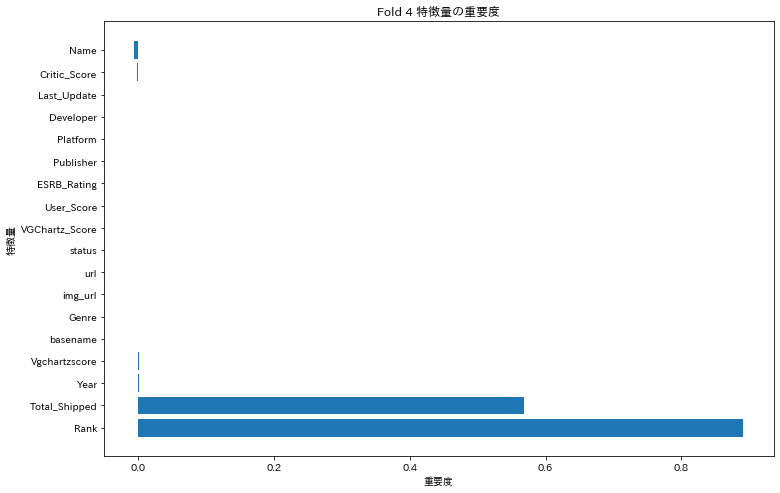


リーダーボード


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,RandomForestMSE,-0.025874,-0.003392,0.252626,0.212544,44.330101,0.252626,0.212544,44.330101,1,True,5
1,WeightedEnsemble_L2,-0.025874,-0.003392,0.257888,0.213131,44.561884,0.005261,0.000586,0.231782,2,True,6
2,LightGBM,-0.214292,-0.097321,0.043644,0.027441,0.991210,0.043644,0.027441,0.991210,1,True,4
3,KNeighborsDist,-0.358502,-0.167653,0.107197,0.105427,0.076478,0.107197,0.105427,0.076478,1,True,2
4,KNeighborsUnif,-0.380025,-0.187312,0.107415,0.104595,0.079085,0.107415,0.104595,0.079085,1,True,1
5,LightGBMXT,-0.438079,-0.200593,0.131237,0.055732,1.406730,0.131237,0.055732,1.406730,1,True,3



RMSE: 0.13546491295574553


In [ ]:
# 学習・推論
gkf = GroupKFold(n_splits=5)

groups = train["Genre"]

cv_result_gln_eval = []

for i, (train_index, test_index) in enumerate(gkf.split(train, train, groups)):
    train_gkf, test_gkf = train.iloc[train_index], train.iloc[test_index]
    
    print(f"Fold {i}")

    model = TabularPredictor(
                    label = "Global_Sales",                  # 目的変数
                    problem_type = "regression",             # 回帰を指定
                    eval_metric = "root_mean_squared_error", # 評価指標
                    verbosity = 0,                           # ログの非表示
                )

    # 学習
    model.fit(
            train_data=train_gkf,
            ag_args_fit={'num_gpus': 1}, # GPUの使用
            time_limit = 30,             # 学習時間の上限
            )

    # 予測
    y_pred = model.predict(test_gkf.drop(["Global_Sales"], axis=1))

    # AutoGluon の解釈性機能
    print("特徴量の重要度")
    feature_importance_df = model.feature_importance(
                                test_gkf,
                                silent = True
                            )

    display(feature_importance_df)
    
    # 特徴量の重要度をグラフ表示
    plt.figure(figsize=(12, 8))
    plt.title(f"Fold {i} 特徴量の重要度")
    plt.xlabel("重要度")
    plt.ylabel("特徴量")
    
    plt.barh(
        feature_importance_df.index,
        feature_importance_df["importance"],
        )
    plt.show()
    print()

    # AutoGluon の機能
    print("リーダーボード")
    display(
        model.leaderboard(
            test_gkf,
            silent = True
        )
    )
    print()

    # AutoGluon の評価機能
    score = model.evaluate_predictions(y_true=test_gkf["Global_Sales"], y_pred=y_pred)

    rmse_gln_eval = score['root_mean_squared_error']

    cv_result_gln_eval.append(rmse_gln_eval)

print("RMSE:", np.mean(cv_result_skl_eval))

In [ ]:
print("RMSE:", round(np.mean(cv_result_skl_eval), 3))

RMSE: 0.135
